# Tasks

1. Construct the timelines of Twitter users
2. Build social network of retweets
3. Calculate assortativity
4. Permutation tests
5. Community detection

In [ ]:
! pip install twarc
! pip install pandas
! pip install numpy
! pip install networkx
! pip install matplotlib

In [127]:
import pandas as pd
from twarc import Twarc2
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone

# 1. Construct the timelines of Twitter users

First connect to the Twitter API using your credentials.

In [2]:
bearer_token = "XXX" # replace the XXX with your bearer token
twarc_client = Twarc2(bearer_token=bearer_token)

Import the file SwissPoliticians.csv and read it as a csv in R. Take into account that separators are tabs.

In [262]:
screen_names = pd.read_csv("SwissPoliticians.csv", sep="\t")
screen_names.head()

,screenName,party
0,andreaskirstein,AL
1,bergerwthur,AL
2,MaeniJ,AL
3,WalterAngst,AL
4,asba_j,BDP


Look up the basic profile information of each user by screenname (see function `user_lookup()` in [twarc2](https://twarc-project.readthedocs.io/en/latest/api/client2/#twarc.client2.Twarc2.user_lookup)).

In [263]:
users = []
for user in twarc_client.user_lookup(screen_names["screenName"], usernames=True):
    users.append(user)
users = pd.json_normalize(users, record_path=['data'])
users.head(2)

,verified,username,pinned_tweet_id,name,profile_image_url,id,description,url,location,protected,created_at,entities.url.urls,public_metrics.followers_count,public_metrics.following_count,public_metrics.tweet_count,public_metrics.listed_count,entities.description.mentions,entities.description.urls,entities.description.hashtags
0,False,andreaskirstein,1180883993480323073,Andreas Kirstein,https://pbs.twimg.com/profile_images/149375950...,25254764,Gemeinderat. Arbeitet in der ETH-Bibliothek. T...,https://t.co/pbzTpZ2ztz,Zürich,False,2009-03-19T07:21:05.000Z,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",734,518,13312,37,NaN,NaN,NaN
1,False,BergerWthur,1489912638012276737,David B. aus W. 📠 🚱🦬✭,https://pbs.twimg.com/profile_images/131178937...,472372843,Alt-Gemeinderat Winterthur (Alternative Liste)...,https://t.co/O4Ttdturoi,Winterthur,False,2012-01-23T21:48:27.000Z,"[{'start': 0, 'end': 23, 'url': 'https://t.co/...",525,373,8181,17,NaN,NaN,NaN


Merge the user information you retrieved from Twitter with the party affiliations from the `SwissPoliticians.csv` file. Remove all protected users from the dataset and save the user dataset to disk.

Hint: convert the screen names in both data frames to lower case, to prevent any merging issues.

In [264]:
screen_names["screenName"] = screen_names["screenName"].str.lower()
users["username"] = users["username"].str.lower()
users = pd.merge(users, screen_names, how="right", left_on="username", right_on="screenName")

In [271]:
N = len(users)
users = users[users["protected"] == False]
print(f"removed {N - len(users)} protected accounts")

removed 55 protected accounts


In [272]:
users.to_csv("users.csv", index=False)

Now retrieve the all tweets from the last 5 days for each user using [twarc](https://twarc-project.readthedocs.io/en/latest/api/client2/#twarc.client2.Twarc2.timeline)'s `timeline()` function. Since we want to build a retweet network, we need to know the user ID of the original tweet for every retweet. To get this information, we need to request an *[expansion](https://developer.twitter.com/en/docs/twitter-api/expansions)*.

It might take a bit to get data. If you run unto the [rate limit](https://developer.twitter.com/en/docs/twitter-api/rate-limits) of the Twitter API, you might have to wait up to 15 min to retrieve all tweets. Twarc will wait and resume the request automatically and print a warning.

Save the result in a file called `timelines.csv` so you can reload it at a later point in time.

**Note:** if you do not manage to download the tweets, we also provide a `timelines.csv` file for you that includes tweets from July 5 to July 12. You can proceed to the next step to load this dataset and continue working with it.

In [273]:
start = datetime(2021, 7, 12, 0, 0, 0, 0, tzinfo=timezone.utc)
end = datetime(2022, 7, 12, 0, 0, 0, 0, tzinfo=timezone.utc)

timelines = []
for i, userID in enumerate(users["id"]):
    if i%50 == 0:
        print(f"{i}/{len(users)}")
    for timeline in twarc_client.timeline(
        userID,
        exclude_retweets=False,
        exclude_replies=False,
        start_time=start,
        end_time=end,
        expansions=["referenced_tweets.id"]
        ):
        timelines.append(timeline)

0/333
50/333
100/333
150/333
200/333
250/333
300/333


rate limit exceeded: sleeping 160.09897208213806 secs


In [274]:
# since we requested an expansion in the referenced_tweets.id field, we have a 
# rather complicated nested JSON structure now. We use the ensure_flattened
# utility to flatten the JSON structure into a more manageable format
from twarc.expansions import ensure_flattened
timelines = ensure_flattened(timelines)

In [275]:
# parse the JSON into a .csv (still not completely flat) and save
timelines = pd.json_normalize(timelines)
timelines.to_csv("timelines.csv", index=False)

# 2. Build social networks of retweets

In [276]:
# load timelines and users from file
timelines = pd.read_csv(
    "timelines.csv",
    dtype={"id":str, "author_id":str, "conversation_id":str}, # load all IDs as string to prevent long integer overflows
    parse_dates=["created_at"] # parse the tweet creation date as datetime
)
users = pd.read_csv(
    "users.csv",
    dtype={"id":str},
    parse_dates=["created_at"]
)

# since the referenced_tweets field contains a list of dictionaries that is 
# stored as a string, we need to parse it first to restore its structure as
# list of dictionaries to interact with it
timelines["referenced_tweets"] = timelines["referenced_tweets"]\
    .apply(lambda x: eval(x) if x == x else np.nan)

/tmp/ipykernel_627609/812648354.py:2: DtypeWarning: Columns (25,26,28,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  timelines = pd.read_csv(


The field `referenced_tweets` currently contains a list where each entry is a tweet object (since we requested the expansion on the field `referenced_tweets.id`:

In [277]:
timelines.loc[0, "referenced_tweets"]

[{'type': 'retweeted',
  'id': '1546388828667006977',
  'author_id': '1391450099205779456',
  'entities': {'urls': [{'start': 209,
     'end': 232,
     'url': 'https://t.co/GGIk9ne4KI',
     'expanded_url': 'https://doi.org/10.35016/ethz-cs-22047-de',
     'display_url': 'doi.org/10.35016/ethz-…'},
    {'start': 233,
     'end': 256,
     'url': 'https://t.co/6OBB5pJQkh',
     'expanded_url': 'https://twitter.com/ETHBildarchiv/status/1546388828667006977/photo/1',
     'display_url': 'pic.twitter.com/6OBB5pJQkh',
     'media_key': '3_1546383410716938241'}],
   'hashtags': [{'start': 174, 'end': 179, 'tag': 'Blog'},
    {'start': 180, 'end': 194, 'tag': 'Crowdsourcing'},
    {'start': 195, 'end': 208, 'tag': 'WerWeissMehr'}],
   'mentions': [{'start': 29,
     'end': 41,
     'username': 'zrh_airport',
     'id': '282510542'}]},
  'source': 'Twitter Web App',
  'possibly_sensitive': False,
  'attachments': {'media_keys': ['3_1546383410716938241'], 'media': [{}]},
  'reply_settings': 'ev

To construct our retweet network, we need to know (a) whether a tweet was a retweet and (b) the ID of the account that posted the tweet that was retweeted. Below we define two functions that help us extract this information from the `referenced_tweets` field:

In [278]:
def check_retweet(entry):
    '''Checks whether a tweet is a retweet'''
    if entry != entry: # NaN check
        return False
    for reference in entry:
        if reference["type"] == "retweeted":
            return True
    return False

def get_retweet_author(entry):
    '''Returns the author ID of the retweeted tweet'''
    if entry != entry: # NaN check
        return np.nan
    for reference in entry:
        if reference["type"] == "retweeted":
            return reference["author_id"]
    return np.nan

Apply the functions `check_retweet()` and `get_retweet_author` to the column `referenced_tweets` and create two new columns `retweeted` and `retweet_user_id` containing the relevant information.

In [279]:
# create reference type columns
timelines["retweeted"] = timelines["referenced_tweets"].apply(check_retweet)
# create referenced tweet ID columns
timelines["retweet_user_id"] = timelines["referenced_tweets"].apply(get_retweet_author)

In [280]:
timelines[["retweeted", "retweet_user_id"]].head()

,retweeted,retweet_user_id
0,True,1391450099205779456
1,True,754651485980459009
2,True,754651485980459009
3,True,1369398904693882885
4,False,NaN


Filter the tweets in the timelines such that you only retain retweets.

In [281]:
timelines = timelines[timelines["retweeted"] == True]

In [282]:
len(timelines)

27384

Now filter the timelines such that the `retweet_user_id` is one of the user IDs in the user list. The command `in` is useful here!

In [283]:
timelines = timelines[timelines["retweet_user_id"].isin(users["id"])]

In [284]:
len(timelines)

1936

In [285]:
# create an empty graph without any nodes or edges
G = nx.Graph()

To build the retweet network, we have to fill the empty graph object we just created with nodes and edges. For this purpose, we prepare a list of nodes and their attributes and a list of edges.

First, construct a list of vertices (nodes)and node attributes containing the user ids,  screen_names, and the **political party label** of the vertices. Each entry of the list has the following form: 

`(id, {"username":username, "party":party})`

Hint: use the function `add_nodes_from()` provided by [networkx](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_nodes_from.html) to add the nodes to the graph. 

Then build a list of edges where every edge is a pair of two users that exchanged at least one retweet with each other (regardless of the direction). Each entry of the list has the following form:  

`(author_id_1, author_id_2)`

Hint: use the function `add_edges_from()` provided by [networkx](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edges_from.html) to add the edges to the graph.

In [286]:
nodes = users[["id", "username", "party"]].dropna(subset=["party"])
node_list = [
    (row["id"], {"username":row["username"], "party":row["party"]}) \
    for i, row in nodes.iterrows()
]
G.add_nodes_from(node_list)

In [287]:
edges = timelines[["author_id", "retweet_user_id"]].drop_duplicates()
edge_list = [(row["author_id"], row["retweet_user_id"]) for i, row in edges.iterrows()]
G.add_edges_from(edge_list)

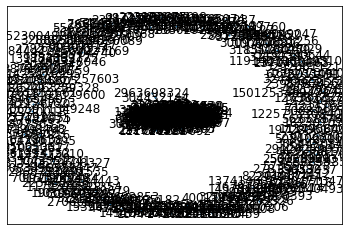

In [288]:
# visualize the graph - this is very ugly!
nx.draw_networkx(G, node_size=1)

# 3. Calculate graph assortativity

Use the function `attribute_assortativity_coefficient()` of [networkx](attribute_assortativity_coefficient) to calculate the assortativity with respect to party labels. How high is the value?

In [289]:
assortativity = nx.attribute_assortativity_coefficient(G, "party")
print(f"assortativity: {assortativity:05f}")

assortativity: 0.529360


To see if the assortativity value fits your expectations, use the [function](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html) `draw_networkx()` to plot the network coloring each node according to the political party label of the politician. Does the pattern of colors fit the value of assortativity?

Hint 1: use the optional function parameters `nodelist` and `node_color` to pass a list of nodes and a list of corresponding colors to the drawing function.  
Hint 2: you can use one of [matplotlibs categorical color maps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) to get a nice series of distinct colors for the parties. 



In [290]:
parties = nodes["party"].unique()
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(len(parties))]
color_dict = {party:color for party, color in zip(parties, colors)}
node_colors = [color_dict[party] for party in nodes["party"]]

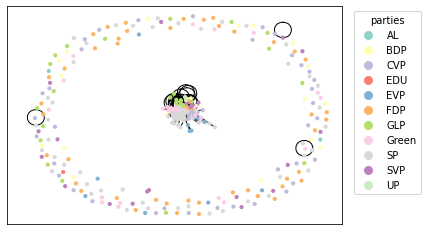

In [291]:
fig, ax = plt.subplots()
nx.draw_networkx(
    G, 
    nodelist=nodes["id"],
    node_color=node_colors,
    node_size=10, 
    with_labels=False,
    ax=ax
)
# let's add a legend! Since draw_network does not do this automatically, we have
# to create custom legend elements to add to the plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
        markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements, # customly made legend handles
    title="parties", # title of the legend
    loc=1, # anchors the legend in the upper right corner
    bbox_to_anchor=[1.25, 1, 0, 0] # puts the legend outside the plot
);

# 4. Permutation tests

The above result looks assortative, but how can we test if it could have happened at random and not because of party identity? Here were are going to test it with a permutation test.

First, let's run a permutation. Perform the same assortativity calculation as above but permuting the party labels of nodes. You can do this very efficiently by using the sample() function when you call the graph_assortativity() function.

In [292]:
parties = nodes["party"].sample(frac=1).values
shuffled_labels = {node:party for node, party in zip(nodes["id"], parties)}
nx.set_node_attributes(G, shuffled_labels, name="party")

In [293]:
nx.attribute_assortativity_coefficient(G, "party")

0.015265517743793292

Is the value much closer to zero?
Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the assortativity without permutation. Is it far or close to the permuted values?

In [294]:
def calculate_shuffled_assortativity(G, nodes):
    parties = nodes["party"].sample(frac=1).values
    shuffled_labels = {node:party for node, party in zip(nodes["id"], parties)}
    nx.set_node_attributes(G, shuffled_labels, name="party")
    return nx.attribute_assortativity_coefficient(G, "party")

In [295]:
perm_assortativities = [calculate_shuffled_assortativity(G, nodes) \
                   for i in range(1000)]

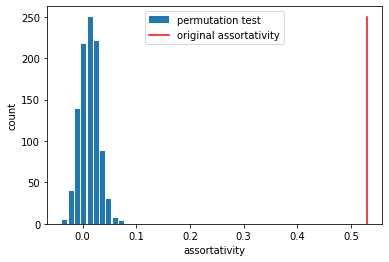

In [296]:
fig, ax = plt.subplots()
ax.hist(perm_assortativities, rwidth=0.8, label="permutation test")
ax.plot([assortativity, assortativity], [0, 250],
        color="r", label="original assortativity")
ax.set_ylabel("count")
ax.set_xlabel("assortativity")
ax.legend(loc=9)

To be sure, let's calculate a p-value for the null hypothesis that the assortativity is zero and the alternative hypothesis that it is positive (what we expected):

In [297]:
perm_assortativities = np.asarray(perm_assortativities)
(1 + sum(perm_assortativities > assortativity)) / len(perm_assortativities)

0.001

After looking at the above results, do you think it is likely that the assortativity we found in the data was produced by chance?

# 5. Community detection

Let's test if Twitter communities match political affiliations. Remove nodes with degree zero in the network and run the [Louvain community detection algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html). Visualize the result coloring nodes by community labels.

In [298]:
G.remove_nodes_from(list(nx.isolates(G)))

In [299]:
import networkx.algorithms.community as nx_comm
communities = nx_comm.louvain_communities(G)

In [300]:
N_communities = len(communities)
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(N_communities)]
color_dict = {community:color for community, color in zip(range(N_communities), colors)}

node_list = []
node_colors = []
for i, community in enumerate(communities):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

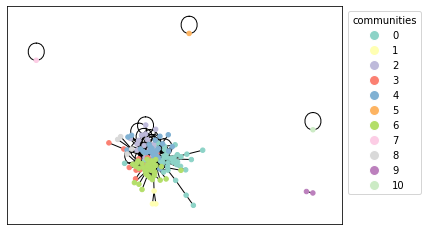

In [302]:
fig, ax = plt.subplots()
nx.draw_networkx(
    G, 
    nodelist=node_list,
    node_color=node_colors,
    node_size=20, 
    with_labels=False,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[1.25, 1, 0, 0]
)

Run the `modularity` [function](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) with the above community labels. Is it high enough to think that the network has a community structure?

In [304]:
nx_comm.modularity(G, communities)

0.4994218275545512

Repeat but using the party labels instead of the communities detected with Louvain. Is it higher or lower? How far is this modularity from the maximal one found with Louvain?

In [320]:
parties = users["party"].unique()
party_communities = []
for party in parties:
    # filter a subset of users that is in the given party and in the graph
    party_members = users[(users["party"] == party) & users["id"].isin(G.nodes)]
    party_communities.append(set(party_members["id"].values))

In [322]:
nx_comm.modularity(G, party_communities)

0.4213398594732011

Finally, to understand which parties are represented in each community, build a data frame for nodes with two columns: one with the party label and another one with the community label. Use the `groupby()` function to print a contingency table. Which party or parties compose each community?

In [340]:
# create a copy of the user data frame with all users that are also in the graph
user_communities = users[users["id"].isin(G.nodes)][["id", "party"]].copy()
user_communities = user_communities.set_index("id")
user_communities["community"] = -1
for i, community in enumerate(communities):
    user_communities.loc[list(community), "community"] = i
user_communities = user_communities\
    .reset_index()\
    .sort_values(by="party")

In [344]:
user_communities\
    .groupby(["party", "community"])\
    .count()\
    .rename(columns={"id":"count"})

count
party community       
AL    4              2
BDP   0              7
      2              1
      3              1
      6              1
CVP   0             15
      8              1
EDU   2              1
EVP   0              2
      1              3
FDP   0              5
      2              6
GLP   2              3
      3             11
Green 0              1
      4             22
      6              2
SP    0              3
      2              2
      4              2
      5              1
      6             34
      7              1
      8              3
SVP   0              3
      2              1
      9              2
      10             1
UP    2              2

# To learn more
* How well can you predict the party of a politician from its neighbors in the network? Here you can use the rule of predicting the party as the majority party among its neighbors and evaluate the accuracy of this approach.
* What would be the results if we use the network of replies? Do you expect assortativity and modularity to be higher or lower?
* If you retrieved data of follower links, you can repeat the above analysis for undirected following relationships. Do you expect a higher or lower assortativity?